In [1]:
using Plots
using CSV
using DataFrames
using Interpolations

In [2]:
# Import battery performance data (taken from graphs and generated by Engauge)
csv_diamond_05C = CSV.File("Diamond cell test, 0.5C.csv")
df_diamond_05C = DataFrame(csv_diamond_05C)
itp_diamond_05C = LinearInterpolation(df_diamond_05C.Ahr, df_diamond_05C.V, extrapolation_bc=Line())

csv_diamond_3C = CSV.File("Diamond cell test, 3C.csv")
df_diamond_3C = DataFrame(csv_diamond_3C)
itp_diamond_3C = LinearInterpolation(df_diamond_3C.Ahr, df_diamond_3C.V, extrapolation_bc=Line())

csv_diamond_5C = CSV.File("Diamond cell test, 5C.csv")
df_diamond_5C = DataFrame(csv_diamond_5C)
itp_diamond_5C = LinearInterpolation(df_diamond_5C.Ahr, df_diamond_5C.V, extrapolation_bc=Line())
  
## IMPORTANT TO UPDATE WHENEVER THE BATTERY DATASHEETS ARE CHANGED
## The order is important, it must be done in sequential order by growing discharge rate
discharge_curves_diamond = (
  (0.5, itp_diamond_05C),
  (3.0, itp_diamond_3C),
  (5.0, itp_diamond_5C)
);

# Capacity of cells in datasheet, in [Ahr]
ahr_datasheet_diamond_cell = 22

# Individual cell max discharge rate
c_diamond_max = 5.5

5.5

In [3]:
# Import battery performance data (taken from graphs and generated by Engauge)
csv_lipo_0_84C = CSV.File("P42A, 0_84C.csv")
df_lipo_0_84C = DataFrame(csv_lipo_0_84C)
itp_lipo_0_84C = LinearInterpolation(df_lipo_0_84C.Ahr, df_lipo_0_84C.V, extrapolation_bc=Line())

csv_lipo_4_2C = CSV.File("P42A, 4_2C.csv")
df_lipo_4_2C = DataFrame(csv_lipo_4_2C)
itp_lipo_4_2C = LinearInterpolation(df_lipo_4_2C.Ahr, df_lipo_4_2C.V, extrapolation_bc=Line())

csv_lipo_10C = CSV.File("P42A, 10C.csv")
df_lipo_10C = DataFrame(csv_lipo_10C)
itp_lipo_10C = LinearInterpolation(df_lipo_10C.Ahr, df_lipo_10C.V, extrapolation_bc=Line())

csv_lipo_20C = CSV.File("P42A, 20C.csv")
df_lipo_20C = DataFrame(csv_lipo_20C)
itp_lipo_20C = LinearInterpolation(df_lipo_20C.Ahr, df_lipo_20C.V, extrapolation_bc=Line())

csv_lipo_30C = CSV.File("P42A, 30C.csv")
df_lipo_30C = DataFrame(csv_lipo_30C)
itp_lipo_30C = LinearInterpolation(df_lipo_30C.Ahr, df_lipo_30C.V, extrapolation_bc=Line())

## IMPORTANT TO UPDATE WHENEVER THE BATTERY DATASHEETS ARE CHANGED
## The order is important, it must be done in sequential order by growing discharge rate
discharge_curves_P42A = (
  (0.84, itp_lipo_0_84C),
  (4.2,  itp_lipo_4_2C),
  (10.0, itp_lipo_10C),
  (20.0, itp_lipo_20C),
  (30.0, itp_lipo_30C)
);

# Capacity of cells in datasheet, in [Ahr]
ahr_datasheet_P42A_cell = 4.2

# Individual cell mass, in [kg]
mass_P42A_cell = 0.070

# Individual cell max discharge rate
c_P42A_max = 45/ahr_datasheet_P42A_cell

# Individual cell nominal energy capacity, in [kwhr]
kwhr_P42A_cell = .0147


0.0147

In [4]:
# Import battery performance data (taken from graphs and generated by Engauge)
# A123Systems cells. Probably shouldn't be changed
csv_a123_1C = CSV.File("ANR26650M1B, 1C.csv")
df_a123_1C = DataFrame(csv_a123_1C)
itp_a123_1C = LinearInterpolation(df_a123_1C.Ahr, df_a123_1C.V, extrapolation_bc=Line())

csv_a123_6C = CSV.File("ANR26650M1B, 6C.csv")
df_a123_6C = DataFrame(csv_a123_6C)
itp_a123_6C = LinearInterpolation(df_a123_6C.Ahr, df_a123_6C.V, extrapolation_bc=Line())

csv_a123_20C = CSV.File("ANR26650M1B, 20C.csv")
df_a123_20C = DataFrame(csv_a123_20C)
itp_a123_20C = LinearInterpolation(df_a123_20C.Ahr, df_a123_20C.V, extrapolation_bc=Line())

## IMPORTANT TO UPDATE WHENEVER THE BATTERIES DATASHEETS ARE CHANGED
## The order is important, it must be done in sequential order by growing discharge rate
discharge_curves_a123 = (
  (1.0,  itp_a123_1C),
  (6.0,  itp_a123_6C),
  (20.0, itp_a123_20C)
);

# Individual cell capacity, in [Ahr]
ahr_a123_cell = 2.65

# Individual cell mass, in [kg]
mass_a123_cell = .076

# Individual cell max discharge rate
c_a123_max = 40

# Individual cell nominal energy capacity, in [kwhr]
kwhr_a123_cell = .00825 * ahr_a123_cell

discharge_index_vector_a123 = getfield.(discharge_curves_a123, 1)

(1.0, 6.0, 20.0)

In [5]:
## Function definitions

# Finds the indices in A which bracket the argument, x. This assumes that A is an ordered set of numbers.
function findNearestBracket(A,x) 
  # find the index which is closest to the value
  tmpIdx = argmin(abs.(A .- x))

  # Find the pair of indices which bracket the value
  if tmpIdx == 1
    lowIdx = 1
    highIdx = 2
  elseif tmpIdx == length(A)
    lowIdx = length(A)-1
    highIdx = length(A)
  else 
    if A[tmpIdx] < x
      lowIdx = tmpIdx
      highIdx = tmpIdx+1
    else
      lowIdx = tmpIdx-1
      highIdx = tmpIdx
    end
  end

  return [lowIdx, highIdx]
end

# Calculate by interpolation the instantaneous pack voltage. It takes into account the discharge rate and the current state of charge.
function instantaneous_pack_voltage(discharge_vector, discharge_curves, c_battery, ahr_accum_cell)
  idx = findNearestBracket(discharge_vector, c_battery)
  lowC = discharge_vector[idx[1]]
  highC = discharge_vector[idx[2]]
  v_instantaneous_lowC = discharge_curves[idx[1]][2]
  v_instantaneous_highC = discharge_curves[idx[2]][2]
  v_instantaneous = batt_v(c_battery, lowC, highC, v_instantaneous_lowC(ahr_accum_cell), v_instantaneous_highC(ahr_accum_cell))

  return v_instantaneous
end


# Linear interpolation of the battery voltage, with discharge rate as the independent variable
function batt_v(x, x1, x2, y1, y2)
  m = (y2-y1)/(x2-x1)
  y = m*(x-x1) + y1
end

batt_v (generic function with 1 method)

# User tunable parameters

In [6]:
# pack = "Diamond"
pack = "P42A"


# Number of parallel cells in pack
num_cols_a123 = 2

# Number of series rows in pack
num_rows_a123 = 21

if pack == "P42A"
  # Number of parallel cells in pack
  num_cols_lipo = 6

  # Number of series rows in pack
  num_rows_lipo = 13
elseif pack == "Diamond"
  ahr_diamond_cell = 16  # Can only equal 16, 22, or 30
  
  # Number of parallel cells in pack
  num_cols_lipo = 1

  # Number of series rows in pack
  num_rows_lipo = 12
end


13

In [7]:

if pack == "P42A"
  discharge_curves_lipo = discharge_curves_P42A;
  mass_lipo_cell = mass_P42A_cell
  ahr_datasheet_lipo_cell = ahr_datasheet_P42A_cell
  ahr_lipo_cell = ahr_datasheet_P42A_cell
  kwhr_lipo_cell = kwhr_P42A_cell
  c_lipo_max = c_P42A_max
elseif pack == "Diamond"
  mass_diamond_cell = (1.500/6) * (ahr_diamond_cell/16)  # Backed out from the Foxtech webpage
  
  # Individual cell nominal energy capacity, in [kwhr]
  kwhr_diamond_cell = .111 * (ahr_diamond_cell / ahr_datasheet_diamond_cell)
  
  discharge_curves_lipo = discharge_curves_diamond;
  mass_lipo_cell = mass_diamond_cell
  ahr_datasheet_lipo_cell = ahr_datasheet_diamond_cell
  ahr_lipo_cell = ahr_datasheet_diamond_cell
  kwhr_lipo_cell = kwhr_diamond_cell
  c_lipo_max = c_diamond_max
end

discharge_index_vector_lipo = getfield.(discharge_curves_lipo, 1)

(0.84, 4.2, 10.0, 20.0, 30.0)

In [8]:
# Airplane MTOW
airplaneMass = 300
climbVelocity = 55*.511

28.105

In [9]:
# Diode forward voltage drop
# https://www.vishay.com/docs/93804/vs-175bqg030hf4.pdf
v_drop_diode = 0.782

# Pack nominal energy capacity
kwhr_a123_pack = kwhr_a123_cell * num_cols_a123 * num_rows_a123
kwhr_lipo_pack = kwhr_lipo_cell * num_cols_lipo * num_rows_lipo

# Pack amps parallel capacity
ahr_a123_pack = ahr_a123_cell * num_cols_a123 
ahr_lipo_pack = ahr_lipo_cell * num_cols_lipo 

# Pack cell mass
mass_a123_pack = mass_a123_cell * num_cols_a123 * num_rows_a123
mass_lipo_pack = mass_lipo_cell * num_cols_lipo * num_rows_lipo


pack_A_label =  string("A123 LiFePo4 (", num_rows_a123, "S", num_cols_a123, "P)")
pack_B_label =  string("Li-ion (", num_rows_lipo, "S, ",num_cols_lipo, "P,", round(ahr_lipo_cell*num_cols_lipo, digits=1), "Ahr)")

println("mass [kg]: " * string(round.([mass_a123_pack mass_lipo_pack], digits = 1)))
println("capacity [Ahr / kwHr]: " * string(round.([ahr_a123_pack kwhr_a123_pack;  ahr_lipo_pack kwhr_lipo_pack], digits = 1)))


mass [kg]: [3.2 5.5]
capacity [Ahr / kwHr]: [5.3 0.9; 25.2 1.1]


In [10]:
# Simulate across time
t = 0
delT = .05

# Power schedule
P_TAKEOFF = 18e3
P_MAX_CONTINUOUS = 12e3
P_SUSTAIN_CLIMB = 10e3
P_SUSTAIN = 6e3

# Plotting variables
t_experiment = Float64[]
I_motor = Float64[]
V_a123 = Float64[]
V_lipo = Float64[]
soc_a123_experiment = Float64[]
soc_lipo_experiment = Float64[]
c_a123_experiment = Float64[]
c_lipo_experiment = Float64[]
P_experiment = Float64[]
E_a123 = Float64[]
E_lipo = Float64[]
soc_20_lipo = []
soc_5_a123 = []
vel_airplane = []
hgt_airplane = []
hgt_dot_airplane = []

c_a123 = 0
c_lipo = 0


## Initial conditions
# Electrical power load
P_elec = P_TAKEOFF

# Start off at full charge
soc_a123 = 1
soc_lipo = 1

v_0_a123 = itp_a123_20C(0)
v_0_lipo = discharge_curves_lipo[1][2](0)

kwhr_accum_a123 = 0
kwhr_accum_lipo = 0

ahr_accum_a123 = 0
ahr_accum_lipo = 0

kineticEnergy = 0
height = 0
velocity = sqrt(2 * kineticEnergy / airplaneMass)


v_instantaneous_a123 = v_0_a123
v_instantaneous_lipo = v_0_lipo

voltage_a123_pack = v_instantaneous_a123 * num_rows_a123
voltage_lipo_pack = (v_instantaneous_lipo * num_rows_lipo) - v_drop_diode

if abs(voltage_lipo_pack - voltage_a123_pack) <= .001
  V_system = voltage_a123_pack
else
  V_system = max(voltage_a123_pack, voltage_lipo_pack )
end

I_a123 = P_elec / V_system
I_lipo = 0


# Run the simulation
for i=1:(800/delT)
  t = t + delT
    
  if 1==0
    # Reduce power according to battery limitations
    if c_lipo > c_lipo_max
      P_elec = P_elec - 1000
    end
  else
    # Reduce power according to schedule and/or battery limitations
    if (t<=60)
      P_elec == P_TAKEOFF
    elseif (t > 60 || (c_lipo > c_lipo_max || c_a123 > c_a123_max)) && P_elec == P_TAKEOFF
      P_elec = P_MAX_CONTINUOUS
    elseif (t > 180 || (c_lipo > c_lipo_max || c_a123 > c_a123_max))  && P_elec == P_MAX_CONTINUOUS
      P_elec = P_SUSTAIN_CLIMB
    elseif (t > 300 || (c_lipo > c_lipo_max || c_a123 > c_a123_max))  && P_elec == P_SUSTAIN_CLIMB
      P_elec = P_SUSTAIN
    end
  end
  
  # Calculate accumulated amp-hour consumption
  ahr_accum_a123 = ahr_accum_a123 + I_a123 * delT/3600
  ahr_accum_lipo = ahr_accum_lipo + I_lipo * delT/3600

  # Saturate AHr consumption
  if ahr_accum_a123 > ahr_a123_pack || ahr_accum_lipo > ahr_lipo_pack
      println("[BATTERY EMPTY] t: " * string(round(t, digits = 1)) * ", A123: " * string(round(c_a123, digits = 1)) * ", lipo: " * string(round(c_lipo, digits = 1)))
      break
  end

  if ahr_accum_lipo > ahr_lipo_pack
#     ahr_accum_lipo = ahr_lipo_pack
  end

  # Calculate accumulated kw-hour consumption
  kwhr_accum_a123 = kwhr_accum_a123 + (I_a123 * V_system) * delT/3600/1000
  kwhr_accum_lipo = kwhr_accum_lipo + (I_lipo * V_system) * delT/3600/1000
  
  # Calculate State of Charge
  soc_a123 = 1 - ahr_accum_a123/ahr_a123_pack
  soc_lipo = 1 - ahr_accum_lipo/ahr_lipo_pack
  
  if soc_5_a123 == [] && soc_a123 < 0.05
    soc_5_a123 = t
  end

  if soc_20_lipo == [] && soc_lipo < 0.20
    soc_20_lipo = t
  end
  
  # Initialize some variables before going into the convergence loop
  isFirstLoop = true

  loopCount = 1
  P_split_pct_low = 0
  P_split_pct_high = 1
  P_split_pct = (P_split_pct_high + P_split_pct_low)/2
  
  # Loop enough times to be sure to converge. Convergence is pretty decent after 15 loops, but is always good to the third digit after 20 loops. Is this optimal? Absolutely not, but it is easy, and since the entire program takes ms to run there's little advantage to optimization.
  while (loopCount < 20) || isFirstLoop == true
    I_a123 = (P_elec * (1-P_split_pct)) / voltage_a123_pack      
    I_lipo = (P_elec * P_split_pct) / voltage_lipo_pack
    
    # Calculate cell discharge rate
    c_a123 = I_a123 / ahr_a123_pack
    c_lipo = I_lipo / ahr_lipo_pack
    
    ## Determine A123 cell voltages
    ahr_accum_cell_a123 = ahr_accum_a123/num_cols_a123
    v_instantaneous_a123 = instantaneous_pack_voltage(discharge_index_vector_a123, discharge_curves_a123, c_a123, ahr_accum_cell_a123)

    ## Determine LiPo cell voltages
    ahr_accum_cell_lipo = ahr_accum_lipo/num_cols_lipo
    v_instantaneous_lipo = instantaneous_pack_voltage(discharge_index_vector_lipo, discharge_curves_lipo, c_lipo, ahr_accum_cell_lipo)

    # Saturate battery voltages
    if v_instantaneous_lipo > 4.2
      v_instantaneous_lipo = 4.2
    end
    
    if v_instantaneous_a123 > 3.4
      v_instantaneous_a123 = 3.4
    end
    
    # Determine pack voltages. This is just the number of batteries in series times the voltage per cell (and not neglecting the diode in the LiPo pack)
    voltage_a123_pack = v_instantaneous_a123 * num_rows_a123
    voltage_lipo_pack = (v_instantaneous_lipo * num_rows_lipo) - v_drop_diode

    # Bisecting search pattern. We're looking for the percentage power split which brings the pack voltages into alignment
    if voltage_lipo_pack > voltage_a123_pack
      P_split_pct_low = P_split_pct
      P_split_pct = (P_split_pct_high + P_split_pct)/2
      P_split_pct_high = P_split_pct_high
    else
      P_split_pct_high = P_split_pct
      P_split_pct_low = P_split_pct_low
      P_split_pct = (P_split_pct_low + P_split_pct)/2
    end
    
    # Increment loop variables.    
    isFirstLoop = false
    loopCount = loopCount + 1
  end
  
  # Simulate airplane
  drag = 150 * (velocity/climbVelocity)^2
  if (velocity < climbVelocity)
    # Below 25m/s, we haevn't taken off yet
    eff = .4
    kineticEnergy = kineticEnergy + (P_elec * eff - velocity * drag) * delT
    velocity = sqrt(2 * kineticEnergy / airplaneMass)
  
    h_dot = 0
  else
    # Above 25m/s, we're putting excess energy into climbing
    eff = .8
    h_dot = (P_elec * eff - velocity * drag)/(airplaneMass*9.805)
    height = height + h_dot*delT
  end
  
  # Some useful console spew
  if 1==0
    println(
        t, ": ", 
        " [",
        round(v_instantaneous_a123, digits=3), " ", 
        round(voltage_a123_pack, digits=2), " ", 
        round(c_a123, digits=1), ", ", 
        round(ahr_accum_a123, digits=4), ", ", 
        round(soc_a123*100, digits=1), 
        "], [", 
        round(v_instantaneous_lipo, digits=3), " ", 
        round(voltage_lipo_pack, digits=2), ", ",
        round(c_lipo, digits=1), ", ", 
        round(ahr_accum_lipo, digits=4), ", ", 
        round(soc_lipo*100, digits=1), 
    " ], :", round(voltage_a123_pack*I_a123 + voltage_lipo_pack*I_lipo))
  end

  
  append!(t_experiment, t)
  append!(c_a123_experiment, c_a123)
  append!(c_lipo_experiment, c_lipo)
  append!(soc_a123_experiment, soc_a123)
  append!(soc_lipo_experiment, soc_lipo)
  append!(V_a123, voltage_a123_pack)
  append!(V_lipo, voltage_lipo_pack)
  append!(P_experiment, P_elec)
  append!(E_a123, kwhr_accum_a123)
  append!(E_lipo, kwhr_accum_lipo)
  append!(vel_airplane, velocity)
  append!(hgt_airplane, height)
  append!(hgt_dot_airplane, h_dot)

end

[soc_5_a123, soc_20_lipo]

[BATTERY EMPTY] t: 555.9, A123: 7.0, lipo: 6.6


2-element Vector{Float64}:
 109.9499999999959
 434.4500000000645

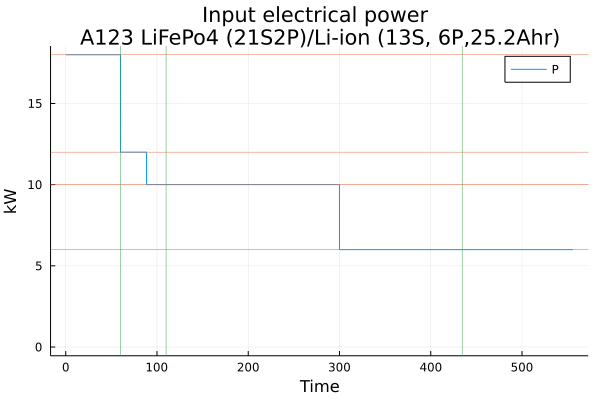

In [11]:
plot(t_experiment, P_experiment./1000, xlabel = "Time", ylabel = "kW", ylims=[0,Inf], title = string("Input electrical power \n", pack_A_label, "/", pack_B_label), label="P")

hline!([P_TAKEOFF, P_MAX_CONTINUOUS, P_SUSTAIN_CLIMB, P_SUSTAIN]./1000, lw=0.5, label="")
vline!([60, soc_5_a123, soc_20_lipo], lw=0.5, label="")

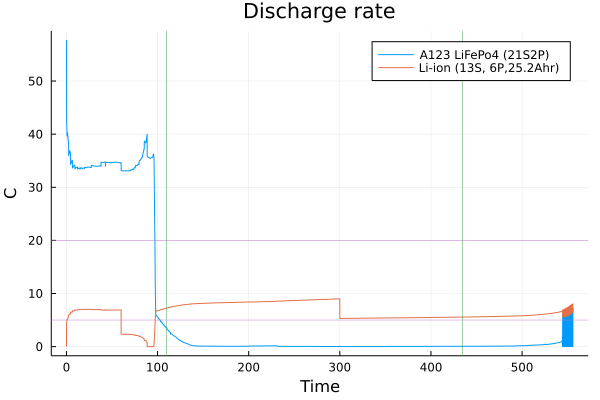

In [12]:
plot(t_experiment, [c_a123_experiment c_lipo_experiment], title="Discharge rate", xlabel = "Time", ylabel = "C", label=[pack_A_label pack_B_label], ylims=[0,Inf])

vline!([soc_5_a123, soc_20_lipo], lw=0.5, label="")
hline!([5,20], label="", lw=0.5) # Max nominal discharge rates
# savefig("plot.png")

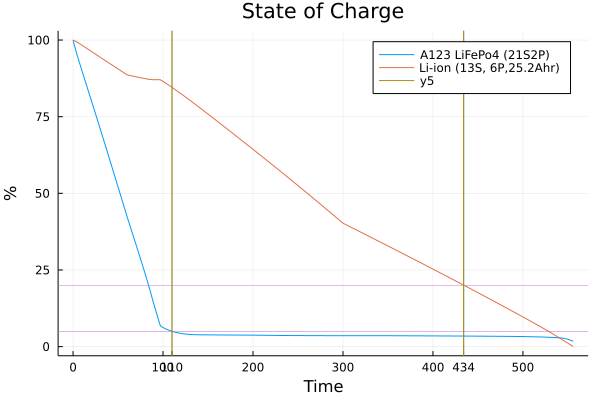

In [13]:
b = plot(t_experiment, [soc_a123_experiment soc_lipo_experiment].*100, title="State of Charge", xlabel = "Time", ylabel = "%", label=[pack_A_label pack_B_label], ylims=[0,Inf])

vline!([soc_5_a123, soc_20_lipo], lw=0.5, label="")
hline!([5,20], label="", lw=0.5)  # SoC limits

old_xticks = xticks(b[1]) # grab xticks of the 1st subplot
new_xticks = (round.([soc_5_a123, soc_20_lipo]), string.(Int.(round.([soc_5_a123, soc_20_lipo]))))
vline!(new_xticks[1])
keep_indices = findall(x -> all(x .≠ new_xticks[1]), old_xticks[1])
merged_xticks = (old_xticks[1][keep_indices] ∪ new_xticks[1], old_xticks[2][keep_indices] ∪ new_xticks[2])
xticks!(merged_xticks)

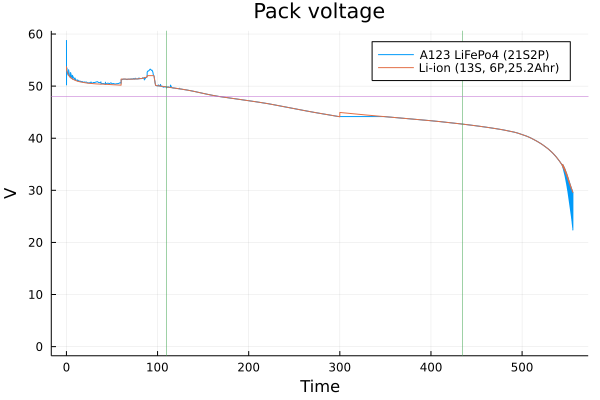

In [14]:
plot(t_experiment, [V_a123 V_lipo], xlabel = "Time", title="Pack voltage", ylabel = "V", label=[pack_A_label pack_B_label], ylims=[0,Inf])

vline!([soc_5_a123, soc_20_lipo], lw=0.5, label="")
hline!([48], label="", lw=0.5) 

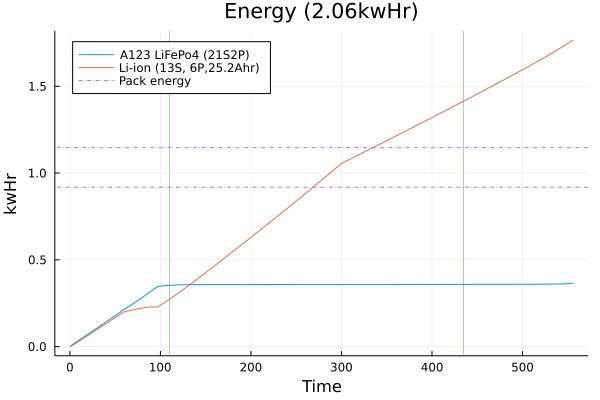

In [15]:
title = "Energy (" * string(round(kwhr_a123_pack + kwhr_lipo_pack, digits = 2)) * "kwHr)"
plot(t_experiment, [E_a123 E_lipo], title=title, xlabel = "Time", ylabel = "kwHr", label=[pack_A_label pack_B_label], ylims=[0,Inf],legend=:topleft)

vline!([soc_5_a123, soc_20_lipo], lw=0.5, label="")
hline!([kwhr_a123_pack, kwhr_lipo_pack], label="Pack energy", linestyle=:dashdot)

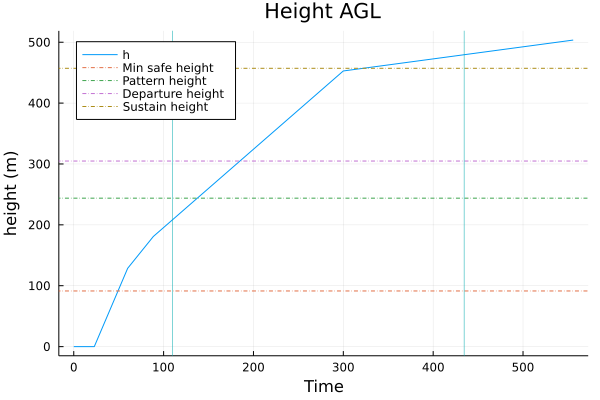

In [16]:
plot(t_experiment, hgt_airplane, xlabel = "Time", ylabel = "height (m)", ylims=[0,Inf], title = string("Height AGL"), label="h",legend=:topleft)

hline!([300*12*.0254], label="Min safe height", linestyle=:dashdot)
hline!([800*12*.0254], label="Pattern height", linestyle=:dashdot)
hline!([1000*12*.0254], label="Departure height", linestyle=:dashdot)
hline!([1500*12*.0254], label="Sustain height", linestyle=:dashdot)

vline!([soc_5_a123, soc_20_lipo], lw=0.5, label="")

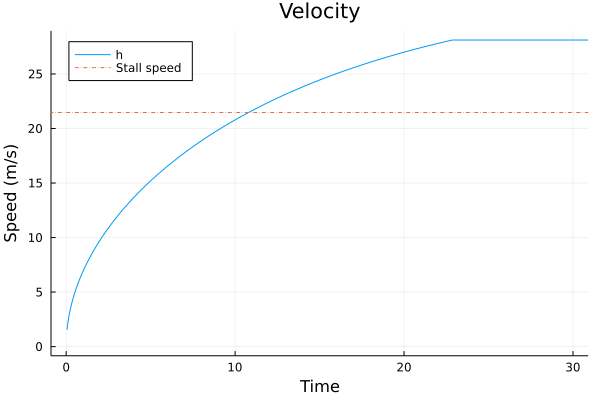

In [17]:
plot(t_experiment, vel_airplane, xlabel = "Time", xlims=[0,30], ylabel = "Speed (m/s)", ylims=[0,Inf], title = string("Velocity"), label="h",legend=:topleft)


hline!([42*.511], label="Stall speed", linestyle=:dashdot)
